## **Init**

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
from scipy.special import softmax
from sklearn import metrics

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
base_path = 'gdrive/My Drive/CS769_Assignments/OOD_NLP'
if not os.path.exists(base_path):
  print("Err : Invalid base path")
else:
  print("Base path is valid!")

Base path is valid!



## **Set values**

In [14]:
# hardcode from calculations
classes = [0, 1, 2, 3, 4, 5]
NUM_CLASSES = len(classes)
FEATURE_LAYER_SIZE = 512

## **Initialize output folders**

In [10]:
def check_path(path):
  if(not os.path.exists(path)):
    print(f"Err: {path} doesn't exist!")
  else:  
    print(f"{path} exists!")

In [11]:
#init names
OUTPUT_FOLDER_NAME = os.path.join(base_path, "outputs")
DATA_NAME = "Reuters6"
OOD_DATA_NAME = "Reuters2"

check_path(OUTPUT_FOLDER_NAME)

gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs exists!


In [12]:
#init features folders
FEATURES_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "features")
FEATURES_DATA_FOLDER = os.path.join(FEATURES_FOLDER, DATA_NAME)
OOD_FEATURES_DATA_FOLDER = os.path.join(FEATURES_FOLDER, OOD_DATA_NAME)
    
check_path(FEATURES_DATA_FOLDER)
check_path(OOD_FEATURES_DATA_FOLDER)
    
#init distances folders
DISTS_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "dists")
DISTS_DATA_FOLDER = os.path.join(DISTS_FOLDER, DATA_NAME)
OOD_DISTS_DATA_FOLDER = os.path.join(DISTS_FOLDER, OOD_DATA_NAME)

check_path(DISTS_DATA_FOLDER)
check_path(OOD_DISTS_DATA_FOLDER)

    
#init closest class folders
CLOSEST_CLASS_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "closest_classes")
CLOSEST_CLASS_DATA_FOLDER = os.path.join(CLOSEST_CLASS_FOLDER, DATA_NAME)
OOD_CLOSEST_CLASS_DATA_FOLDER = os.path.join(CLOSEST_CLASS_FOLDER, OOD_DATA_NAME)

check_path(CLOSEST_CLASS_DATA_FOLDER)
check_path(OOD_CLOSEST_CLASS_DATA_FOLDER)

    
#init labels folders
LABELS_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "labels")
LABELS_DATA_FOLDER = os.path.join(LABELS_FOLDER, DATA_NAME)

check_path(LABELS_DATA_FOLDER)

    
#init means folders
MEANS_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "means")
MEANS_DATA_FOLDER = os.path.join(MEANS_FOLDER, DATA_NAME)

check_path(MEANS_DATA_FOLDER)
    
#init radius folders
RADIUS_FOLDER = os.path.join(OUTPUT_FOLDER_NAME, "radius")
RADIUS_DATA_FOLDER = os.path.join(RADIUS_FOLDER, DATA_NAME)

check_path(RADIUS_DATA_FOLDER)

gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/features/Reuters6 exists!
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/features/Reuters2 exists!
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/dists/Reuters6 exists!
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/dists/Reuters2 exists!
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/closest_classes/Reuters6 exists!
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/closest_classes/Reuters2 exists!
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/labels/Reuters6 exists!
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/means/Reuters6 exists!
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/radius/Reuters6 exists!


## **Load data**

In [22]:
#load train features
train_features = [] 
for classID in range(NUM_CLASSES):
    save_name = "{0}_train_features.npy".format(classID)
    save_location = os.path.join(FEATURES_DATA_FOLDER, save_name)
    check_path(save_location)
    x = np.load(save_location)
    print(x.shape)
    train_features.append(x)

train_features = np.array(train_features, dtype='object')
print(train_features.shape)

gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/features/Reuters6/0_train_features.npy exists!
(1431, 512)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/features/Reuters6/1_train_features.npy exists!
(2598, 512)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/features/Reuters6/2_train_features.npy exists!
(39, 512)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/features/Reuters6/3_train_features.npy exists!
(189, 512)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/features/Reuters6/4_train_features.npy exists!
(99, 512)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/features/Reuters6/5_train_features.npy exists!
(233, 512)
(6,)


In [27]:
#load test features
save_name = "test_features.npy"
save_location = os.path.join(FEATURES_DATA_FOLDER, save_name)
test_features = np.load(save_location)
print(test_features.shape)

(1987, 512)


In [28]:
#load ood features
save_name = "ood_set_features.npy"
save_location = os.path.join(OOD_FEATURES_DATA_FOLDER, save_name)
ood_set_features = np.load(save_location)
print(ood_set_features.shape)

(202, 512)


In [30]:
#load class means
save_name = "train_class_means.npy"
save_location = os.path.join(MEANS_DATA_FOLDER, save_name)
class_means = np.load(save_location)
print(class_means.shape)

(6, 512)


In [31]:
#load class radii
save_name = "train_class_radii.npy"
save_location = os.path.join(RADIUS_DATA_FOLDER, save_name)
class_radii = np.load(save_location)
print(class_radii.shape)

(6,)


In [33]:
#load train distances & closest classes
train_distances = []
train_closest_classes = []
for classID in range(NUM_CLASSES):
    #load distances
    save_name = "{0}_train_distances.npy".format(classID)
    save_location = os.path.join(DISTS_DATA_FOLDER, save_name)
    check_path(save_location)
    x = np.load(save_location)
    print(x.shape)
    train_distances.append(x)
    #load closest classes
    save_name = "{0}_train_closest_classes.npy".format(classID)
    save_location = os.path.join(CLOSEST_CLASS_DATA_FOLDER, save_name)
    check_path(save_location)
    x = np.load(save_location)
    print(x.shape)
    train_closest_classes.append(x)
train_distances = np.asarray(train_distances)
train_closest_classes = np.asarray(train_closest_classes)
print(train_distances.shape)
print(train_closest_classes.shape)

gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/dists/Reuters6/0_train_distances.npy exists!
(1431,)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/closest_classes/Reuters6/0_train_closest_classes.npy exists!
(1431,)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/dists/Reuters6/1_train_distances.npy exists!
(2598,)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/closest_classes/Reuters6/1_train_closest_classes.npy exists!
(2598,)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/dists/Reuters6/2_train_distances.npy exists!
(39,)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/closest_classes/Reuters6/2_train_closest_classes.npy exists!
(39,)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/dists/Reuters6/3_train_distances.npy exists!
(189,)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/closest_classes/Reuters6/3_train_closest_classes.npy exists!
(189,)
gdrive/My Drive/CS769_Assignments/OOD_NLP/outputs/dists/Reuters6/4_train_distances.npy exists!
(99,)
gdrive/My Drive/C

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [35]:
#load test distances
save_name = "test_distances.npy"
save_location =  os.path.join(DISTS_DATA_FOLDER, save_name)
test_distances = np.load(save_location)
print(test_distances.shape)

(1987,)


In [34]:
#load OOD distances
save_name = "ood_set_distances.npy"
save_location =  os.path.join(OOD_DISTS_DATA_FOLDER, save_name)
ood_set_distances = np.load(save_location)
print(ood_set_distances.shape)

(202,)


In [37]:
#load test closest classes
save_name = "test_closest_classes.npy"
save_location =  os.path.join(CLOSEST_CLASS_DATA_FOLDER, save_name)
test_closest_classes = np.load(save_location)
print(test_closest_classes.shape)

(1987,)


In [36]:
#load ood set closest classes
save_name = "ood_set_closest_classes.npy"
save_location =  os.path.join(OOD_CLOSEST_CLASS_DATA_FOLDER, save_name)
ood_set_closest_classes = np.load(save_location)
print(ood_set_closest_classes.shape)

(202,)


In [40]:
RESULTS = {}

## **Calculate TNR at 95% TPR**

In [38]:
#sort scores
test_dists_sorted = sorted(test_distances)
ood_set_dists_sorted = sorted(ood_set_distances)

In [39]:
threshold = test_dists_sorted[int(0.95*len(test_dists_sorted))]
print(threshold)

0.18378527507160758


In [41]:
out_of_bound_scores = [a for a in ood_set_dists_sorted if a>threshold]
TOTAL_OUT_OF_BOUND_SCORES = len(out_of_bound_scores)
TOTAL_IN_BOUND_SCORES = len(ood_set_dists_sorted) - TOTAL_OUT_OF_BOUND_SCORES
print("Total out-of-bound scores - " + str(TOTAL_OUT_OF_BOUND_SCORES))
print("Total in-bound scores - " + str(TOTAL_IN_BOUND_SCORES))
RESULTS["TNR at 95% TPR"] = TOTAL_OUT_OF_BOUND_SCORES*100/len(ood_set_dists_sorted)
print("TNR at 95% TPR - {0}%".format(RESULTS["TNR at 95% TPR"]))

Total out-of-bound scores - 133
Total in-bound scores - 69
TNR at 95% TPR - 65.84158415841584%


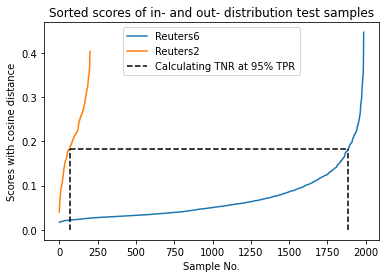

<Figure size 432x288 with 0 Axes>

In [48]:
plt.plot(test_dists_sorted)
plt.plot(ood_set_dists_sorted)

x_coordinates = [int(0.95*len(test_dists_sorted)), int(0.95*len(test_dists_sorted))]
y_coordinates = [0, threshold]
plt.plot(x_coordinates, y_coordinates, 'k--')

x_coordinates = [TOTAL_IN_BOUND_SCORES, int(0.95*len(test_dists_sorted))]
y_coordinates = [threshold, threshold]
plt.plot(x_coordinates, y_coordinates, 'k--')

x_coordinates = [TOTAL_IN_BOUND_SCORES, TOTAL_IN_BOUND_SCORES]
y_coordinates = [0, threshold]
plt.plot(x_coordinates, y_coordinates, 'k--')

plt.title("Sorted scores of in- and out- distribution test samples")
plt.xlabel("Sample No.")
plt.ylabel("Scores with cosine distance")
plt.legend([DATA_NAME, OOD_DATA_NAME, "Calculating TNR at 95% TPR"])
plt.savefig("TNR_at_95%_TPR.png")
plt.show()
plt.draw()

## **Calculate Detection Accuracy**

In [51]:
y_pred = []
y_true = []
for i in range(len(test_distances)):
    y_true.append(0)
    class_idx = int(i/1000)
    if(test_distances[i]>class_radii[class_idx]):
        y_pred.append(1)
    else:
        y_pred.append(0)

for i in range(len(ood_set_distances)):
    y_true.append(1)
    class_idx = int(i/1000)
    if(ood_set_distances[i]>class_radii[ood_set_closest_classes[i]]):
        y_pred.append(1)
    else:
        y_pred.append(0)

In [52]:
RESULTS["Detection Accuracy"] = metrics.accuracy_score(y_true, y_pred)
print(RESULTS["Detection Accuracy"])

0.7277295568752855


## **Calculate AUPR_{out} score**

In [53]:
precision, recall, thresholds = metrics.precision_recall_curve(y_true, np.concatenate((test_distances, ood_set_distances)), pos_label=1)

No handles with labels found to put in legend.


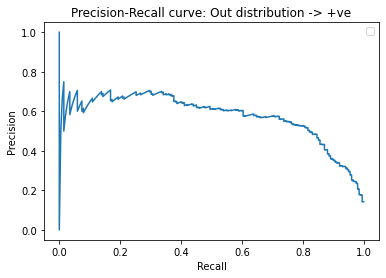

In [54]:
from matplotlib import pyplot
# plot model roc curve
pyplot.plot(recall, precision)
plt.title("Precision-Recall curve: Out distribution -> +ve")
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
plt.savefig("PR_Curve_out.png")
pyplot.show()

In [55]:
x = metrics.auc(recall, precision)
RESULTS["AUPR_out"] = x
print(RESULTS["AUPR_out"])

0.5740016994300943


## **Calculate AUPR_{in} score**

In [56]:
precision, recall, thresholds = metrics.precision_recall_curve(y_true, 1-np.concatenate((test_distances, ood_set_distances)), pos_label=0)

No handles with labels found to put in legend.


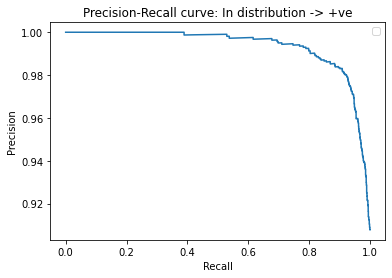

In [57]:
from matplotlib import pyplot
# plot model roc curve
pyplot.plot(recall, precision)
plt.title("Precision-Recall curve: In distribution -> +ve")
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
plt.savefig("PR_Curve_in.png")
pyplot.show()

In [58]:
x = metrics.auc(recall, precision)
RESULTS["AUPR_in"] = x
print(RESULTS["AUPR_in"])

0.9933945256878199


## **Calculate AUROC**

In [59]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true, np.concatenate((test_distances, ood_set_distances)))
roc_auc = auc(fpr, tpr)
RESULTS["AUROC"] = roc_auc
print(RESULTS["AUROC"])

0.9400858052589356


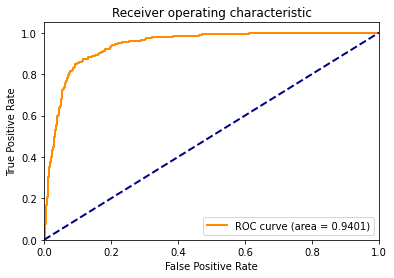

In [60]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("ROC_Curve.png")
plt.show()

## **Overall results**

In [62]:
from pprint import pprint
pprint(RESULTS)

{'AUPR_in': 0.9933945256878199,
 'AUPR_out': 0.5740016994300943,
 'AUROC': 0.9400858052589356,
 'Detection Accuracy': 0.7277295568752855,
 'TNR at 95% TPR': 65.84158415841584}
